In [2]:
from __future__ import print_function
import os
import pickle

import numpy as np
import time
import datetime

from sklearn import svm, datasets
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import scipy.io
import scipy.integrate
from astropy.convolution import convolve, Box1DKernel

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.path import Path as mpath
from scipy.optimize import least_squares

import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_rows = 90

np.set_printoptions(threshold=np.nan)

plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.rc('text', usetex=True)

###############
## COMPUTER ##
###############

laptop = False

In [3]:
###############
## CONSTANTS ##
###############

#von karman's constant
kappa = 0.41

#fluid density kg/m/m/m
rhof_titan = 5.3
rhof_twt   = 14.5
rhof_earth = 1.2
rhof_mars  = 0.02
rhof_venus = 66
rhof_pluto = 9.1e-5

#particle density kg/m/m/m
rhop_titan = 1000
rhop_twt   = 2500 #others used
rhop_earth = 2650
rhop_mars  = 3000
rhop_venus = 3000
rhop_pluto = 494

#kinematic viscosity m*m/s
nu_titan = 1.2e-6
nu_twt = 1.2e-6
nu_earth = 1.5e-5
nu_mars  = 6.5e-4
nu_venus = 4.7e-6
nu_pluto = 2.4e-2

#gravity m/s/s
g_titan = 1.352
g_twt   = 9.81
g_earth = 9.81
g_mars  = 3.75
g_venus = 8.77
g_pluto = 0.658

#fluid pressure kg/m/s/s
p_titan = 1.47e+5
p_twt   = 1.25e+6
p_earth = 1.02e+5
p_mars  = 7e+2
p_venus = 9.15e+6
p_pluto = 1

#surface atmosphere temperature K
t_titan = 94
t_twt   = 293
t_earth = 300
t_mars  = 220
t_venus = 729
t_pluto = 37

#PBL height maximums m
H_titan = 3000

H_earth = 2000
H_mars  = 6000
H_venus = 2000
H_pluto = 1000

#heat capacity ratio (approximate)
gamma_titan = 1.47 #N2 at 92K
gamma_twt   = 1.4
gamma_earth = 1.4
gamma_mars  = 1.35 #CO2 at 273K
gamma_venus = 1.23 #CO2 at 673K
gamma_pluto = 1.47 #N2 at 92K

#mean free path m
lambda_titan = 1.23e-8 #DOI: 10.1111/maps.12924
lambda_twt   = 5.33*10**-9 #sutherlands method air http://hyperphysics.phy-astr.gsu.edu/hbase/Kinetic/menfrevis.html
lambda_earth = 6.8e-8 #wiki
lambda_mars  = 1e-5 #phys today
lambda_venus = 1.55e-9 #DOI: 10.1111/maps.12924
lambda_pluto = 8.207343991052203*10**-4 #sutherlands method N2 http://hyperphysics.phy-astr.gsu.edu/hbase/Kinetic/menfrevis.html

#coriolis frequency at 45 lat 1/s
f_titan = 2**0.5*2*np.pi/(24*60*60)/(15+22/24)
f_twt   = 2**0.5*2*np.pi/(24*60*60)
f_earth = 2**0.5*2*np.pi/(24*60*60)
f_mars  = 2**0.5*2*np.pi/(24*60*60)/(1+2/3/24)
f_venus = 2**0.5*2*np.pi/(24*60*60)/(5832/24)
f_pluto = 2**0.5*2*np.pi/(24*60*60)/(6+9.5/25)

#speed of sound m/s
c_titan = (gamma_titan*p_titan/rhof_titan)**0.5
c_twt   = (gamma_twt*p_twt/rhof_twt)**0.5
c_earth = (gamma_earth*p_earth/rhof_earth)**0.5
c_mars  = (gamma_mars*p_mars/rhof_mars)**0.5
c_venus = (gamma_venus*p_venus/rhof_venus)**0.5
c_pluto = (gamma_pluto*p_pluto/rhof_pluto)**0.5

In [70]:
def us_IW82(d,g,rhop,rhof,rep):
    X = 0.006/1000/10**0.5
    
    if (rep>0.03)&(rep<=0.3):
        a = 0.2*((1+X/rhop/g/d**2.5)/(1+2.5*rep))**0.5
    elif (rep>0.3)&(rep<=10):
        a = 0.129*((1+X/rhop/g/d**2.5)/(1.928*rep**0.092-1))**0.5

    elif rep>10:
        a = 0.12*(1+X/rhop/g/d**2.5)**0.5*(1-0.0858*np.exp(-0.0671*(rep-10)))
    else:
        a = np.nan
        
    return a*((rhop-rhof)*g*d/rhof)**0.5

In [71]:
## FLUID ##

l_min = -6
l_max = 4

u_min = -6
u_max = 3

l = np.logspace(l_min,l_max,100)
u = np.logspace(u_min,u_max,100)

L, U = np.meshgrid(l,u)

Re_titan = U*L/nu_titan
Re_twt   = U*L/nu_twt
Re_earth = U*L/nu_earth
Re_mars  = U*L/nu_mars
Re_venus = U*L/nu_venus
Re_pluto = U*L/nu_pluto

M_titan = u/c_titan
M_twt   = u/c_twt
M_earth = u/c_earth
M_mars  = u/c_mars
M_venus = u/c_venus
M_pluto = u/c_pluto

Kn_titan = lambda_titan/l
Kn_twt   = lambda_twt/l
Kn_earth = lambda_earth/l
Kn_mars  = lambda_mars/l
Kn_venus = lambda_venus/l
Kn_pluto = lambda_pluto/l

u_Rec_titan = 10**3*nu_titan/l
u_Rec_twt   = 10**3*nu_twt/l
u_Rec_earth = 10**3*nu_earth/l
u_Rec_mars  = 10**3*nu_mars/l
u_Rec_venus = 10**3*nu_venus/l
u_Rec_pluto = 10**3*nu_pluto/l

#need to alter this with a buoyancy Fr=u/N/H
u_Frc_titan = (g_titan*l)**0.5
u_Frc_twt   = (g_twt*l)**0.5
u_Frc_earth = (g_earth*l)**0.5
u_Frc_mars  = (g_mars*l)**0.5
u_Frc_venus = (g_venus*l)**0.5
u_Frc_pluto = (g_pluto*l)**0.5

#do rossby u/l/f
u_Roc_titan = 10**2*f_titan*l
u_Roc_twt   = 10**2*f_twt*l
u_Roc_earth = 10**2*f_earth*l
u_Roc_mars  = 10**2*f_mars*l
u_Roc_venus = 10**2*f_venus*l
u_Roc_pluto = 10**2*f_pluto*l

Re = [Re_titan,Re_twt,Re_earth,Re_mars,Re_venus,Re_pluto]
print(np.min(Re))
print(np.max(Re))

4.1666666666666665e-11
8333333333333.334


In [72]:
## SEDIMENT ##

d_min = -6
d_max = -1

us_min = -3
us_max = 2

d = np.logspace(d_min,d_max,100)
us = np.logspace(us_min,us_max,100)

D, US = np.meshgrid(d,us)

Rep_titan = us*d/nu_titan
Rep_twt   = us*d/nu_twt
Rep_earth = us*d/nu_earth
Rep_mars  = us*d/nu_mars
Rep_venus = us*d/nu_venus
Rep_pluto = us*d/nu_pluto

Gap_titan = (rhop_titan/rhof_titan-1)*g_titan*D**3/nu_titan**2
Gap_twt   = (rhop_twt/rhof_twt-1)*g_twt*D**3/nu_twt**2
Gap_earth = (rhop_earth/rhof_earth-1)*g_earth*D**3/nu_earth**2
Gap_mars  = (rhop_mars/rhof_mars-1)*g_mars*D**3/nu_mars**2
Gap_venus = (rhop_venus/rhof_venus-1)*g_venus*D**3/nu_venus**2
Gap_pluto = (rhop_pluto/rhof_pluto-1)*g_pluto*D**3/nu_pluto**2

Knp_titan = lambda_titan/d
Knp_twt   = lambda_twt/d
Knp_earth = lambda_earth/d
Knp_mars  = lambda_mars/d
Knp_venus = lambda_venus/d
Knp_pluto = lambda_pluto/d

usc_IW82_titan = np.empty_like(d)
for i in np.arange(0,np.shape(d)[0]):
    usc_IW82_titan[i] = us_IW82(d[i],g_titan,rhop_titan,rhof_titan,Rep_titan[i])
Repc_IW82_titan = usc_IW82_titan*d/nu_titan

usc_IW82_twt = np.empty_like(d)
for i in np.arange(0,np.shape(d)[0]):
    usc_IW82_twt[i] = us_IW82(d[i],g_twt,rhop_twt,rhof_twt,Rep_twt[i])
Repc_IW82_twt   = usc_IW82_twt*d/nu_twt

usc_IW82_earth = np.empty_like(d)
for i in np.arange(0,np.shape(d)[0]):
    usc_IW82_earth[i] = us_IW82(d[i],g_earth,rhop_earth,rhof_earth,Rep_earth[i])
Repc_IW82_earth = usc_IW82_earth*d/nu_earth
    
usc_IW82_mars = np.empty_like(d)
for i in np.arange(0,np.shape(d)[0]):
    usc_IW82_mars[i] = us_IW82(d[i],g_mars,rhop_mars,rhof_mars,Rep_mars[i])
Repc_IW82_mars = usc_IW82_mars*d/nu_mars
      
usc_IW82_venus = np.empty_like(d)
for i in np.arange(0,np.shape(d)[0]):
    usc_IW82_venus[i] = us_IW82(d[i],g_venus,rhop_venus,rhof_venus,Rep_venus[i])
Repc_IW82_venus = usc_IW82_venus*d/nu_venus
      
usc_IW82_pluto = np.empty_like(d)
for i in np.arange(0,np.shape(d)[0]):
    usc_IW82_pluto[i] = us_IW82(d[i],g_pluto,rhop_pluto,rhof_pluto,Rep_pluto[i])
Repc_IW82_pluto = usc_IW82_pluto*d/nu_pluto 

Gap = [Gap_titan,Gap_twt,Gap_earth,Gap_mars,Gap_venus,Gap_pluto]
print(np.min(Gap))
print(np.max(Gap))

6.201387746527776e-09
1167756465517.242


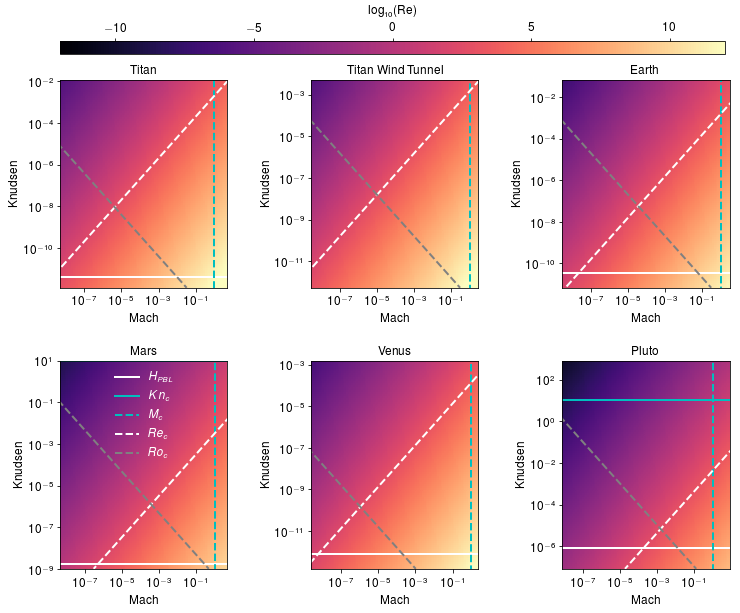

In [74]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

v1= -12
v2= 12

LW=2
LC='c'

fs = 12

fig = plt.gcf()

ax1 = plt.subplot(231)

sc1 = ax1.pcolormesh(M_titan, Kn_titan, np.log10(Re_titan),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot([10**-10,10**2], [lambda_titan/H_titan,lambda_titan/H_titan], lw=LW, color='w',label='$H_{PBL}$')
sc2 = ax1.plot([10**-10,10**2], [10,10], lw=LW, color='c',label='$Kn_c$')
sc2 = ax1.plot([1,1], [10**-14,10**4], '--', lw=LW, color='c',label='$M_c$')
sc2 = ax1.plot(u_Rec_titan/c_titan, lambda_titan/l, '--', lw=LW, color='w',label='$Re_c$')
sc2 = ax1.plot(u_Roc_titan/c_titan, lambda_titan/l, '--', lw=LW, color='grey',label='$Ro_c$')

ax1.set_title('Titan', fontsize=fs)
ax1.set_xlabel('Mach', fontsize=fs)
ax1.set_ylabel('Knudsen', fontsize=fs)
    
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([np.min(M_titan),np.max(M_titan)])
plt.ylim([np.min(Kn_titan),np.max(Kn_titan)])

ax1 = plt.subplot(232)

sc1 = ax1.pcolormesh(M_twt, Kn_twt, np.log10(Re_twt),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot([10**-10,10**2], [10,10], lw=LW, color='c',label='$Kn_c$')
sc2 = ax1.plot([1,1], [10**-14,10**4], '--', lw=LW, color='c',label='$M_c$')
sc2 = ax1.plot(u_Rec_twt/c_twt, lambda_twt/l, '--', lw=LW, color='w',label='$Re_c$')
sc2 = ax1.plot(u_Roc_twt/c_twt, lambda_twt/l, '--', lw=LW, color='grey',label='$Ro_c$')

ax1.set_title('Titan Wind Tunnel', fontsize=fs)
ax1.set_xlabel('Mach', fontsize=fs)
ax1.set_ylabel('Knudsen', fontsize=fs)
    
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([np.min(M_twt),np.max(M_twt)])
plt.ylim([np.min(Kn_twt),np.max(Kn_twt)])

ax1 = plt.subplot(233)

sc1 = ax1.pcolormesh(M_earth, Kn_earth, np.log10(Re_earth),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot([10**-10,10**2], [lambda_earth/H_earth,lambda_earth/H_earth], lw=LW, color='w',label='$H_{PBL}$')
sc2 = ax1.plot([10**-10,10**2], [10,10], lw=LW, color='c',label='$Kn_c$')
sc2 = ax1.plot([1,1], [10**-14,10**4], '--', lw=LW, color='c',label='$M_c$')
sc2 = ax1.plot(u_Rec_earth/c_earth, lambda_earth/l, '--', lw=LW, color='w',label='$Re_c$')
sc2 = ax1.plot(u_Roc_earth/c_earth, lambda_earth/l, '--', lw=LW, color='grey',label='$Ro_c$')

ax1.set_title('Earth', fontsize=fs)
ax1.set_xlabel('Mach', fontsize=fs)
ax1.set_ylabel('Knudsen', fontsize=fs)
    
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([np.min(M_earth),np.max(M_earth)])
plt.ylim([np.min(Kn_earth),np.max(Kn_earth)])

ax1 = plt.subplot(234)

sc1 = ax1.pcolormesh(M_mars, Kn_mars, np.log10(Re_mars),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot([10**-10,10**2], [lambda_mars/H_mars,lambda_mars/H_mars], lw=LW, color='w',label='$H_{PBL}$')
sc2 = ax1.plot([10**-10,10**2], [10,10], lw=LW, color='c',label='$Kn_c$')
sc2 = ax1.plot([1,1], [10**-14,10**4], '--', lw=LW, color='c',label='$M_c$')
sc2 = ax1.plot(u_Rec_mars/c_mars, lambda_mars/l, '--', lw=LW, color='w',label='$Re_c$')
sc2 = ax1.plot(u_Roc_mars/c_mars, lambda_mars/l, '--', lw=LW, color='grey',label='$Ro_c$')

ax1.set_title('Mars', fontsize=fs)
ax1.set_xlabel('Mach', fontsize=fs)
ax1.set_ylabel('Knudsen', fontsize=fs)

leg = ax1.legend(loc=0,frameon=False,fontsize=fs)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
    
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([np.min(M_mars),np.max(M_mars)])
plt.ylim([np.min(Kn_mars),np.max(Kn_mars)])

ax1 = plt.subplot(235)

sc1 = ax1.pcolormesh(M_venus, Kn_venus, np.log10(Re_venus),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot([10**-10,10**2], [lambda_venus/H_venus,lambda_venus/H_venus], lw=LW, color='w',label='$H_{PBL}$')
sc2 = ax1.plot([10**-10,10**2], [10,10], lw=LW, color='c',label='$Kn_c$')
sc2 = ax1.plot([1,1], [10**-14,10**4], '--', lw=LW, color='c',label='$M_c$')
sc2 = ax1.plot(u_Rec_venus/c_venus, lambda_venus/l, '--', lw=LW, color='w',label='$Re_c$')
sc2 = ax1.plot(u_Roc_venus/c_venus, lambda_venus/l, '--', lw=LW, color='grey',label='$Ro_c$')

ax1.set_title('Venus', fontsize=fs)
ax1.set_xlabel('Mach', fontsize=fs)
ax1.set_ylabel('Knudsen', fontsize=fs)
    
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([np.min(M_venus),np.max(M_venus)])
plt.ylim([np.min(Kn_venus),np.max(Kn_venus)])

ax1 = plt.subplot(236)

sc1 = ax1.pcolormesh(M_pluto, Kn_pluto, np.log10(Re_pluto),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot([10**-10,10**2], [lambda_pluto/H_pluto,lambda_pluto/H_pluto], lw=LW, color='w',label='$H_{PBL}$')
sc2 = ax1.plot([10**-10,10**2], [10,10], lw=LW, color='c',label='$Kn_c$')
sc2 = ax1.plot([1,1], [10**-14,10**4], '--', lw=LW, color='c',label='$M_c$')
sc2 = ax1.plot(u_Rec_pluto/c_pluto, lambda_pluto/l, '--', lw=LW, color='w',label='$Re_c$')
sc2 = ax1.plot(u_Roc_pluto/c_pluto, lambda_pluto/l, '--', lw=LW, color='grey',label='$Ro_c$')

ax1.set_title('Pluto', fontsize=fs)
ax1.set_xlabel('Mach', fontsize=fs)
ax1.set_ylabel('Knudsen', fontsize=fs)
    
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([np.min(M_pluto),np.max(M_pluto)])
plt.ylim([np.min(Kn_pluto),np.max(Kn_pluto)])

cbar2_ax = fig.add_axes([0.125, 0.92, 0.77, 0.02])

cbar2 = fig.colorbar(sc1, cax=cbar2_ax, orientation='horizontal')
cbar2.ax.xaxis.set_ticks_position('top')
cbar2.set_label('$\\log_{10}$(Re)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.tick_params(labelsize=fs)

fig.subplots_adjust(hspace=0.35)
fig.subplots_adjust(wspace=0.5)

fig.set_size_inches(12, 9, forward=True)
# plt.savefig('some_name72.pdf', bbox_inches='tight')

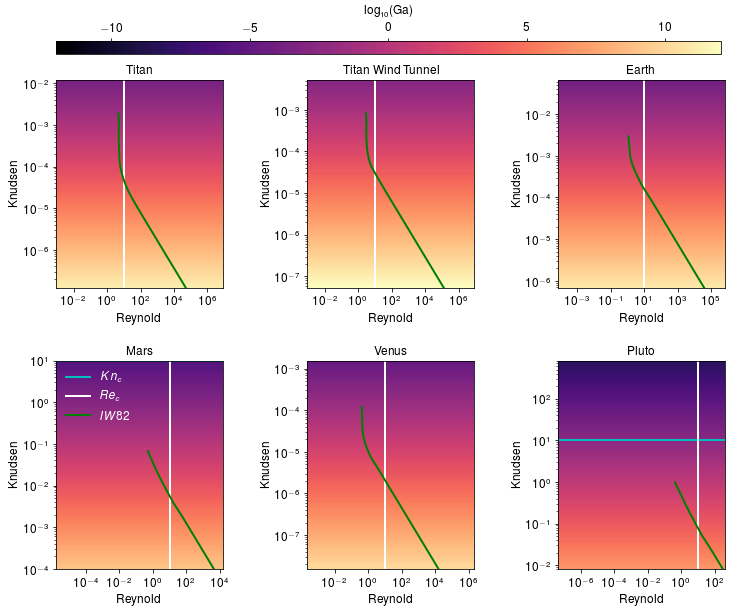

In [75]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

v1= -12
v2= 12

LW=2
LC='c'

fs = 12

fig = plt.gcf()

ax1 = plt.subplot(231)

sc1 = ax1.pcolormesh(Rep_titan, Knp_titan, np.log10(Gap_titan.T),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot([10**-8,10**7], [10,10], lw=LW, color='c',label='$Kn_c$')
sc2 = ax1.plot([10,10], [10**-8,10**3], lw=LW, color='w',label='$Re_c$')
sc2 = ax1.plot(Repc_IW82_titan, Knp_titan, lw=LW, color='g',label='$IW82$')

ax1.set_title('Titan', fontsize=fs)
ax1.set_xlabel('Reynold', fontsize=fs)
ax1.set_ylabel('Knudsen', fontsize=fs)
    
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([np.min(Rep_titan),np.max(Rep_titan)])
plt.ylim([np.min(Knp_titan),np.max(Knp_titan)])

ax1 = plt.subplot(232)

sc1 = ax1.pcolormesh(Rep_twt, Knp_twt, np.log10(Gap_twt.T),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot([10**-8,10**7], [10,10], lw=LW, color='c',label='$Kn_c$')
sc2 = ax1.plot([10,10], [10**-8,10**3], lw=LW, color='w',label='$Re_c$')
sc2 = ax1.plot(Repc_IW82_twt, Knp_twt, lw=LW, color='g',label='$IW82$')

ax1.set_title('Titan Wind Tunnel', fontsize=fs)
ax1.set_xlabel('Reynold', fontsize=fs)
ax1.set_ylabel('Knudsen', fontsize=fs)
    
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([np.min(Rep_twt),np.max(Rep_twt)])
plt.ylim([np.min(Knp_twt),np.max(Knp_twt)])

ax1 = plt.subplot(233)

sc1 = ax1.pcolormesh(Rep_earth, Knp_earth, np.log10(Gap_earth.T),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot([10**-8,10**7], [10,10], lw=LW, color='c',label='$Kn_c$')
sc2 = ax1.plot([10,10], [10**-8,10**3], lw=LW, color='w',label='$Re_c$')
sc2 = ax1.plot(Repc_IW82_earth, Knp_earth, lw=LW, color='g',label='$IW82$')

ax1.set_title('Earth', fontsize=fs)
ax1.set_xlabel('Reynold', fontsize=fs)
ax1.set_ylabel('Knudsen', fontsize=fs)
    
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([np.min(Rep_earth),np.max(Rep_earth)])
plt.ylim([np.min(Knp_earth),np.max(Knp_earth)])

ax1 = plt.subplot(234)

sc1 = ax1.pcolormesh(Rep_mars, Knp_mars, np.log10(Gap_mars.T),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot([10**-8,10**7], [10,10], lw=LW, color='c',label='$Kn_c$')
sc2 = ax1.plot([10,10], [10**-8,10**3], lw=LW, color='w',label='$Re_c$')
sc2 = ax1.plot(Repc_IW82_mars, Knp_mars, lw=LW, color='g',label='$IW82$')

ax1.set_title('Mars', fontsize=fs)
ax1.set_xlabel('Reynold', fontsize=fs)
ax1.set_ylabel('Knudsen', fontsize=fs)

leg = ax1.legend(loc=0,frameon=False,fontsize=fs)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
    
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([np.min(Rep_mars),np.max(Rep_mars)])
plt.ylim([np.min(Knp_mars),np.max(Knp_mars)])

ax1 = plt.subplot(235)

sc1 = ax1.pcolormesh(Rep_venus, Knp_venus, np.log10(Gap_venus.T),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot([10**-8,10**7], [10,10], lw=LW, color='c',label='$Kn_c$')
sc2 = ax1.plot([10,10], [10**-8,10**3], lw=LW, color='w',label='$Re_c$')
sc2 = ax1.plot(Repc_IW82_venus, Knp_venus, lw=LW, color='g',label='$IW82$')

ax1.set_title('Venus', fontsize=fs)
ax1.set_xlabel('Reynold', fontsize=fs)
ax1.set_ylabel('Knudsen', fontsize=fs)
    
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([np.min(Rep_venus),np.max(Rep_venus)])
plt.ylim([np.min(Knp_venus),np.max(Knp_venus)])

ax1 = plt.subplot(236)

sc1 = ax1.pcolormesh(Rep_pluto, Knp_pluto, np.log10(Gap_pluto.T),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot([10**-8,10**7], [10,10], lw=LW, color='c',label='$Kn_c$')
sc2 = ax1.plot([10,10], [10**-8,10**3], lw=LW, color='w',label='$Re_c$')
sc2 = ax1.plot(Repc_IW82_pluto, Knp_pluto, lw=LW, color='g',label='$IW82$')

ax1.set_title('Pluto', fontsize=fs)
ax1.set_xlabel('Reynold', fontsize=fs)
ax1.set_ylabel('Knudsen', fontsize=fs)
    
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([np.min(Rep_pluto),np.max(Rep_pluto)])
plt.ylim([np.min(Knp_pluto),np.max(Knp_pluto)])

cbar2_ax = fig.add_axes([0.125, 0.92, 0.77, 0.02])

cbar2 = fig.colorbar(sc1, cax=cbar2_ax, orientation='horizontal')
cbar2.ax.xaxis.set_ticks_position('top')
cbar2.set_label('$\\log_{10}$(Ga)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.tick_params(labelsize=fs)

fig.subplots_adjust(hspace=0.35)
fig.subplots_adjust(wspace=0.5)

fig.set_size_inches(12, 9, forward=True)

In [76]:
Dz = np.copy(D)
USz = np.copy(US)

Lz = 10*np.ones_like(D)
Uz = USz*np.log(Lz/Dz)/kappa

X_titan = np.copy(Uz)
X_titan[Dz<=10*lambda_titan] = np.nan
X_titan[Dz*USz<=10**2*nu_titan] = np.nan
X_titan[Uz>=c_titan] = np.nan
X_titan[Lz<=10*lambda_titan] = np.nan
X_titan[Lz>=H_titan] = np.nan
X_titan[Lz*Uz<=10**3*nu_titan] = np.nan
X_titan[Uz/Lz<=10**2*f_titan] = np.nan

X_twt = np.copy(Uz)
X_twt[Dz<=10*lambda_twt] = np.nan
X_twt[Dz*USz<=10**2*nu_twt] = np.nan
X_twt[Uz>=c_twt] = np.nan
X_twt[Lz<=10*lambda_twt] = np.nan
# X_twt[Lz>=H_twt] = np.nan
X_twt[Lz*Uz<=10**3*nu_twt] = np.nan
X_twt[Uz/Lz<=10**2*f_twt] = np.nan

X_earth = np.copy(Uz)
X_earth[Dz<=10*lambda_earth] = np.nan
X_earth[Dz*USz<=10**2*nu_earth] = np.nan
X_earth[Uz>=c_earth] = np.nan
X_earth[Lz<=10*lambda_earth] = np.nan
X_earth[Lz>=H_earth] = np.nan
X_earth[Lz*Uz<=10**3*nu_earth] = np.nan
X_earth[Uz/Lz<=10**2*f_earth] = np.nan

X_mars = np.copy(Uz)
X_mars[Dz<=10*lambda_mars] = np.nan
X_mars[Dz*USz<=10**2*nu_mars] = np.nan
X_mars[Uz>=c_mars] = np.nan
X_mars[Lz<=10*lambda_mars] = np.nan
X_mars[Lz>=H_mars] = np.nan
X_mars[Lz*Uz<=10**3*nu_mars] = np.nan
X_mars[Uz/Lz<=10**2*f_mars] = np.nan

X_venus = np.copy(Uz)
X_venus[Dz<=10*lambda_venus] = np.nan
X_venus[Dz*USz<=10**2*nu_venus] = np.nan
X_venus[Uz>=c_venus] = np.nan
X_venus[Lz<=10*lambda_venus] = np.nan
X_venus[Lz>=H_venus] = np.nan
X_venus[Lz*Uz<=10**3*nu_venus] = np.nan
X_venus[Uz/Lz<=10**2*f_venus] = np.nan

X_pluto = np.copy(Uz)
X_pluto[Dz<=10*lambda_pluto] = np.nan
X_pluto[Dz*USz<=10**2*nu_pluto] = np.nan
X_pluto[Uz>=c_pluto] = np.nan
X_pluto[Lz<=10*lambda_pluto] = np.nan
X_pluto[Lz>=H_pluto] = np.nan
X_pluto[Lz*Uz<=10**3*nu_pluto] = np.nan
X_pluto[Uz/Lz<=10**2*f_pluto] = np.nan

XX = [X_titan,X_twt,X_earth,X_mars,X_venus,X_pluto]
print(np.nanmin(XX))
print(np.nanmax(XX))

0.014173330967998788
411.721599855569


/home/andrew/Documents


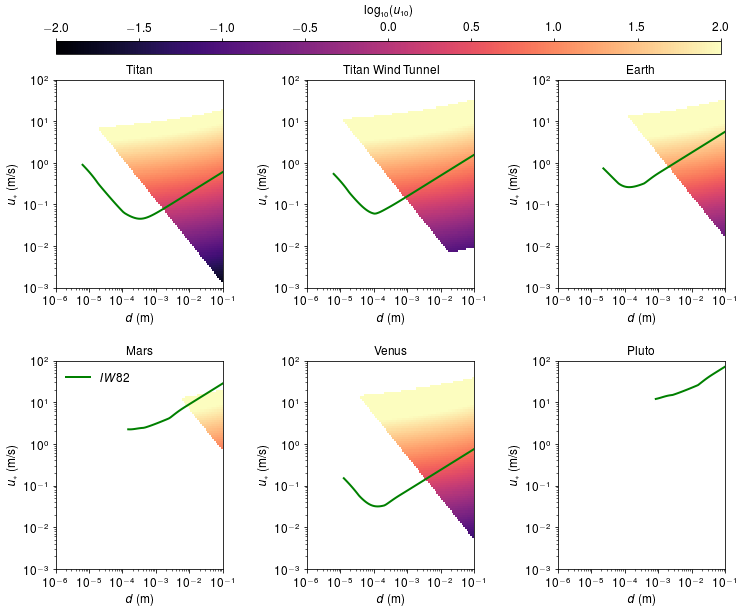

In [78]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

v1= -2
v2= 2

LW=2
LC='c'

fs = 12

fig = plt.gcf()

ax1 = plt.subplot(231)

sc1 = ax1.pcolormesh(d, us, np.log10(X_titan),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot(d, usc_IW82_titan, lw=LW, color='g',label='$IW82$')

ax1.set_title('Titan', fontsize=fs)
ax1.set_xlabel('$d$ (m)', fontsize=fs)
ax1.set_ylabel('$u_*$ (m/s)', fontsize=fs)

ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(232)

sc1 = ax1.pcolormesh(d, us, np.log10(X_twt),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot(d, usc_IW82_twt, lw=LW, color='g',label='$IW82$')

ax1.set_title('Titan Wind Tunnel', fontsize=fs)
ax1.set_xlabel('$d$ (m)', fontsize=fs)
ax1.set_ylabel('$u_*$ (m/s)', fontsize=fs)

ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(233)

sc1 = ax1.pcolormesh(d, us, np.log10(X_earth),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot(d, usc_IW82_earth, lw=LW, color='g',label='$IW82$')

ax1.set_title('Earth', fontsize=fs)
ax1.set_xlabel('$d$ (m)', fontsize=fs)
ax1.set_ylabel('$u_*$ (m/s)', fontsize=fs)

ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(234)

sc1 = ax1.pcolormesh(d, us, np.log10(X_mars),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot(d, usc_IW82_mars, lw=LW, color='g',label='$IW82$')

ax1.set_title('Mars', fontsize=fs)
ax1.set_xlabel('$d$ (m)', fontsize=fs)
ax1.set_ylabel('$u_*$ (m/s)', fontsize=fs)

leg = ax1.legend(loc=0,frameon=False,fontsize=fs)

ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(235)

sc1 = ax1.pcolormesh(d, us, np.log10(X_venus),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot(d, usc_IW82_venus, lw=LW, color='g',label='$IW82$')

ax1.set_title('Venus', fontsize=fs)
ax1.set_xlabel('$d$ (m)', fontsize=fs)
ax1.set_ylabel('$u_*$ (m/s)', fontsize=fs)

ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(236)

sc1 = ax1.pcolormesh(d, us, np.log10(X_pluto),cmap='magma',vmin=v1,vmax=v2)

sc2 = ax1.plot(d, usc_IW82_pluto, lw=LW, color='g',label='$IW82$')

ax1.set_title('Pluto', fontsize=fs)
ax1.set_xlabel('$d$ (m)', fontsize=fs)
ax1.set_ylabel('$u_*$ (m/s)', fontsize=fs)

ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

cbar2_ax = fig.add_axes([0.125, 0.92, 0.77, 0.02])

cbar2 = fig.colorbar(sc1, cax=cbar2_ax, orientation='horizontal')
cbar2.ax.xaxis.set_ticks_position('top')
cbar2.set_label('$\\log_{10}(u_{10})$',fontsize=fs)
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.tick_params(labelsize=fs)

fig.subplots_adjust(hspace=0.35)
fig.subplots_adjust(wspace=0.5)

fig.set_size_inches(12, 9, forward=True)

In [4]:
###############
## TITAN WIND TUNNEL ##
###############


u_twt = np.asarray([1.9482352941176468,2.148823529411765,2.2894117647058825,2.460588235294118,2.5594117647058834,2.650000000000001,2.7594117647058836,2.840588235294119,2.949411764705884,3.0305882352941196,3.0806404320987677,3.1396455156136556,3.2199264705882378,3.3007747821350795,3.3507021604938303,3.3603472222222264,3.37027596223675,3.381339415395792,3.370275962236751,3.370275962236752,3.370275962236752,3.370559640522882,3.370275962236753,3.3810557371096657,3.370843318809013,3.3702759622367546])
z_twt = np.asarray([0.00010752688172054048,0.0011111111111112085,0.0020519713261649766,0.0030555555555556585,0.004121863799283254,0.005062724014337015,0.006066308243727683,0.007069892473118365,0.00807347670250904,0.009327956989247398,0.010047395625912732,0.01107585650913765,0.012074068542855955,0.013798252964733013,0.01564343278463655,0.017337368357007,0.019091801628390692,0.020967230297800843,0.02272166356918453,0.02520206922872697,0.027833719135802498,0.030404871343864798,0.03303652125094032,0.03630339699765477,0.03975176584140891,0.04301864158812336])

z_twt_roughnesselements = 125e-6/2
z_twt_walldatumoffset = 0

# z_twt = z_twt - (z_twt_roughnesselements + z_twt_walldatumoffset)

#from devon burr paper
us_twt = kappa/0.0187/100
z0_twt = np.exp(-5.7669)/100

zp_twt = z_twt*us_twt/nu_twt
up_twt = u_twt/us_twt

zp_vis = np.logspace(0,1,100)
up_vis = zp_vis

B = 5.6
delup = 1

zp_log = np.logspace(1,3,100)
up_log = np.log(zp_log)/kappa+B-delup

z_vis = np.logspace(-4,-2.4,100)
u_vis = us_twt**2*z_vis/nu_twt

# y1 = 2.2894117647058825
# x1 = 0.0020519713261649766
# u_vis = y1/x1*z_vis

z_log = np.logspace(-2.2,-1.8,100)
u_log = us_twt/kappa*np.log(z_log/z0_twt)

/home/andrew/Documents


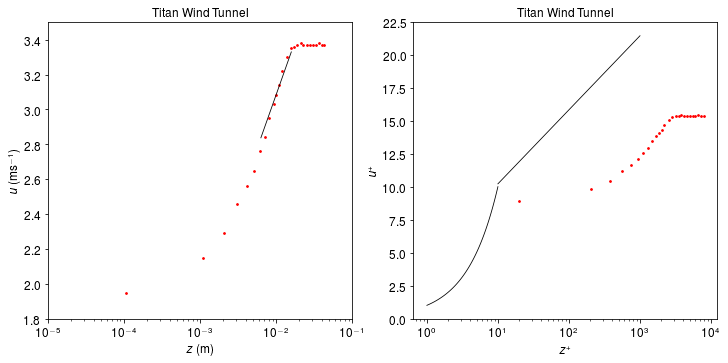

In [5]:

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 3
LW = 0.8
fs = 12

fig = plt.gcf()

ax1 = plt.subplot(221)

s = ax1.scatter(z_twt, u_twt, s=S, c='r')

s = ax1.plot(z_vis, u_vis, lw=LW, c='k')
s = ax1.plot(z_log, u_log, lw=LW, c='k')

ax1.set_title('Titan Wind Tunnel', fontsize=fs)
ax1.set_xlabel('$z$ (m)', fontsize=fs)
ax1.set_ylabel('$u$ (ms$^{-1}$)', fontsize=fs)

ax1.set_xscale('log')

plt.ylim([1.8,3.5])
plt.xlim([10**-5,10**-1])

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(222)

s = ax1.scatter(zp_twt, up_twt, s=S, c='r')

s = ax1.plot(zp_vis, up_vis, lw=LW, c='k')
s = ax1.plot(zp_log, up_log, lw=LW, c='k')

ax1.set_title('Titan Wind Tunnel', fontsize=fs)
ax1.set_xlabel('$z^{+}$', fontsize=fs)
ax1.set_ylabel('$u^{+}$', fontsize=fs)

ax1.set_xscale('log')

# plt.ylim([1.8,3.5])
# plt.xlim([10**-5,10**-1])

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)


fig.set_size_inches(12, 12, forward=True)